# Natural Language Processing (NLP)

**BrainStation**

## Introduction

In this notebook, we will employ Natural Language Processing (NLP) techniques to see the most common words in the drug reviews. We will use different topic modeling models to identify clusters or groups of similar words within a body of text.

***

## Table of Contents

- [The Dataset](#the-dataset)
- [Exploratory Data Analysis (EDA)](#eda)
- [NLP](#nlp)
- [Conclusion](#conclusion)

***

## The Dataset <a class="anchor" id="the-dataset"></a>

Let's import the relevant packages to analyze the data.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import string
from collections import Counter

# For performing regex operations
import re

# For progress bars
from tqdm import tqdm

***
## Exploratory Data Analysis (EDA) <a class="anchor" id="eda"></a>

In [2]:
cd /Users/justinanguyen/Desktop/BrainStation/Projects/Capstone/Justina_Nguyen_Capstone_Submission

/Users/justinanguyen/Desktop/BrainStation/Projects/Capstone/Justina_Nguyen_Capstone_Submission


Let's take a look at the data.

In [3]:
# Reading the csv file into a dataframe
drug_df = pd.read_csv('./clean_preprocessed_drug_reviews.csv', index_col=0)

# Checking the first 5 rows of the dataframe
drug_df.head()

uniqueID                      duration               date  \
0    jwillou   Taken for less than 1 month  February 27, 2023   
1    Slow...       Taken for 1 to 6 months      April 3, 2023   
2   KS in...       Taken for 1 to 6 months     April 18, 2023   
3  Smithy...       Taken for 1 to 6 months     March 14, 2023   
4     Philly  Taken for 6 months to 1 year   February 6, 2022   

                drugName                                             review  \
0   Wegovy (semaglutide)  I have been taking Wegovy for 1 week and 2 day...   
1   Wegovy (semaglutide)  Starting week 9 with the second injection of 1...   
2   Wegovy (semaglutide)  Tomorrow I will take my 3rd shot of .5mg (prev...   
3  Ozempic (semaglutide)  I was hesitant to try Ozempic for weight loss ...   
4   Wegovy (semaglutide)  6 months. -65 pounds. Hypertension gone. Pre D...   

   rating  upvotes         drug  page  
0      10      622  semaglutide     1  
1       7      216  semaglutide     1  
2      10      167  semaglutide     1  
3      10      231  semaglutide     1  
4      10      709  semaglutide     1

In [4]:
print(f'This dataset has {drug_df.shape[0]} rows and {drug_df.shape[1]} columns.')

This dataset has 4733 rows and 9 columns.


## NLP <a class="anchor" id="nlp"></a>

For NLP, we will be focusing on the `review` column.

Let's make a function to preprocess the text.

In [5]:
# Code adapted from BrainStation (25 May 2023) NLP Pre-Processing Basics 
# Function to clean text
def my_preprocessor(text):
    '''
    This function takes text as input. It first parses through sentences in order to help part-of-speech (POS) 
    tagging work best as good POS tags help out lemmatization. Each sentence gets broken into tokens (words),
    lemmatized, converted to lowercase, then stripped of non alphabetic or space characters (which there 
    shouldn't be). Then, any zero length strings or stopwords are removed and the result for the fully processed 
    sentence is appended to the final output.
    
    Parameters:
    -----------
    text: any kind of text
    
    Returns:
    --------
    output: a processed and clean list of words
    
    ''' 
    # Create dictionary for the part-of-speech tagging
    pos_map = {"J":wordnet.ADJ,
           "V":wordnet.VERB,
           "N":wordnet.NOUN,
           "R":wordnet.ADV}
    lemmatizer = WordNetLemmatizer()
    # List of english stopwords in lowercase
    stops = set(stopwords.words("english"))
    # First break into sentences to get pos tagging to work best
    as_sent = sent_tokenize(text,language='english')
    processed = []
    for sent in as_sent:
        # Break each sentence into words
        tokens = word_tokenize(sent)
        # Get pos tags for lemmatization
        pos_tags = nltk.pos_tag(tokens)
        mapped_tags = list((tag[0],pos_map.get(tag[1][0],wordnet.NOUN)) for tag in pos_tags)
        lemmas = list(lemmatizer.lemmatize(*tagged) for tagged in mapped_tags)
        # Convert to lower after lemmatization
        as_str = " ".join(list(lemma.lower() for lemma in lemmas))
        # Remove unwanted punctuation and numbers
        cleaned = "".join(char for char in as_str if char in "abcdefghijklmnopqrstuvwxyz ")
        # Double check no empty strings and add to processed
        cleaned = list(word for word in cleaned.split() if len(word) > 0 and word not in stops )
        processed.extend(cleaned)
    return processed

Now that we have our function, we want to use this code to clean and preprocess the drug reviews, store the cleaned reviews for each drug, and count the occurrences of individual words in the reviews for each drug. 

In [6]:
brand_drugs = ['Wegovy (semaglutide)', 'Ozempic (semaglutide)', 'Contrave (bupropion / naltrexone)',\
               'Saxenda (liraglutide)', 'Xenical (orlistat)', 'Alli (orlistat)', 'Qsymia (phentermine / topiramate)']
clean_drug_reviews = {drug: [] for drug in brand_drugs}
word_counts_by_drug = {drug: Counter() for drug in brand_drugs}

# Cleans and splits text
# And counts the words
for drug_name in brand_drugs:
    for review in drug_df.loc[drug_df['drugName'] == drug_name, 'review']:
        # Join the preprocessed words from a review into a single string with words separated by a space
        clean = " ".join(my_preprocessor(review))  
        # Add the preprocessed review to the list of clean reviews for a specific drug
        clean_drug_reviews[drug_name].append(clean) 
        # Split the preprocessed review into individual words
        words = clean.split()
        # Adds the individuals words to the list of words for a specific drug
        word_counts_by_drug[drug_name].update(words)

We can extract and see the 20 most common word for each drug.

In [7]:
# Creates a dictionary of the top 20 words for each drug
top_words_by_drug = {drug: word_counts.most_common(20) for drug, word_counts in word_counts_by_drug.items()}
top_words_by_drug

{'Wegovy (semaglutide)': [('week', 210),
  ('lose', 200),
  ('effect', 169),
  ('wegovy', 164),
  ('side', 162),
  ('weight', 152),
  ('mg', 147),
  ('eat', 145),
  ('day', 143),
  ('dose', 139),
  ('start', 137),
  ('take', 133),
  ('month', 133),
  ('nausea', 123),
  ('get', 111),
  ('feel', 111),
  ('go', 105),
  ('first', 101),
  ('lb', 99),
  ('pound', 96)],
 'Ozempic (semaglutide)': [('week', 81),
  ('ozempic', 67),
  ('weight', 63),
  ('lose', 58),
  ('take', 55),
  ('mg', 53),
  ('day', 44),
  ('effect', 43),
  ('first', 41),
  ('side', 40),
  ('dose', 37),
  ('start', 37),
  ('nt', 36),
  ('eat', 35),
  ('month', 34),
  ('loss', 32),
  ('feel', 31),
  ('nausea', 30),
  ('go', 26),
  ('lb', 25)],
 'Contrave (bupropion / naltrexone)': [('take', 1794),
  ('contrave', 1689),
  ('day', 1682),
  ('week', 1588),
  ('lose', 1435),
  ('start', 1305),
  ('nt', 1304),
  ('weight', 1204),
  ('side', 1153),
  ('effect', 1150),
  ('eat', 1037),
  ('go', 923),
  ('pill', 839),
  ('month', 83

We see that there are some common words above that we do not want listed. We shall remove the brand names of the drugs (`wegovy`, `ozempic`, `saxenda`, `contrave`, `xenical`, `alli`, `qsymia`) and some other common words (`nt`, `lb`, `lbs`, `oz`, `u`, `etc`, `mg`, `take`, `pound`, `go`, `nd`, `th`, `kg`, `ago`, `day`, `week`, `month`, `get`, `happen`, `yet`, `however`, `l`, `yo`).

In [8]:
# modified preprocessor to exclude certain words
def my_preprocessor2(text):
    '''
    This function takes text as input. It first parses through sentences in order to help part-of-speech (POS) 
    tagging work best as good POS tags help out lemmatization. Each sentence gets broken into tokens (words),
    lemmatized, converted to lowercase, then stripped of non alphabetic or space characters (which there 
    shouldn't be). Then, any zero length strings or stopwords are removed and the result for the fully processed 
    sentence is appended to the final output.
    
    Parameters:
    -----------
    text: any kind of text
    
    Returns:
    --------
    output: a processed and clean list of words
    
    ''' 
    # Create dictionary for the part-of-speech tagging
    pos_map = {"J":wordnet.ADJ,
           "V":wordnet.VERB,
           "N":wordnet.NOUN,
           "R":wordnet.ADV}
    lemmatizer = WordNetLemmatizer()
    # List of english stopwords in lowercase
    stops = set(stopwords.words("english"))
    # remove drug name and common words
    stops.update(["wegovy", "ozempic", "saxenda", "contrave", "xenical", "alli", "qsymia", "nt", "lb", "lbs",\
                  "oz", "u", "etc", "mg", "take", "pound", "go", "nd", "th", "kg", "ago", "day", "week",\
                  "month", "get", "happen", "yet", "however", "l", "yo"])
    # First break into sentences to get pos tagging to work best
    as_sent = sent_tokenize(text,language='english')
    processed = []
    for sent in as_sent:
        # Break each sentence into words
        tokens = word_tokenize(sent)
        # Get pos tags for lemmatization
        pos_tags = nltk.pos_tag(tokens)
        mapped_tags = list((tag[0],pos_map.get(tag[1][0],wordnet.NOUN)) for tag in pos_tags)
        lemmas = list(lemmatizer.lemmatize(*tagged) for tagged in mapped_tags)
        # Convert to lower after lemmatization
        as_str = " ".join(list(lemma.lower() for lemma in lemmas))
        # Remove unwanted punctuation and numbers
        cleaned = "".join(char for char in as_str if char in "abcdefghijklmnopqrstuvwxyz ")
        # Double check no empty strings and add to processed
        cleaned = list(word for word in cleaned.split() if len(word) > 0 and word not in stops )
        processed.extend(cleaned)
    return processed

We will rerun the code above to clean and preprocess our data with our updated `my_preprocessor2` function. We can plot the 10 most common words for each drug.

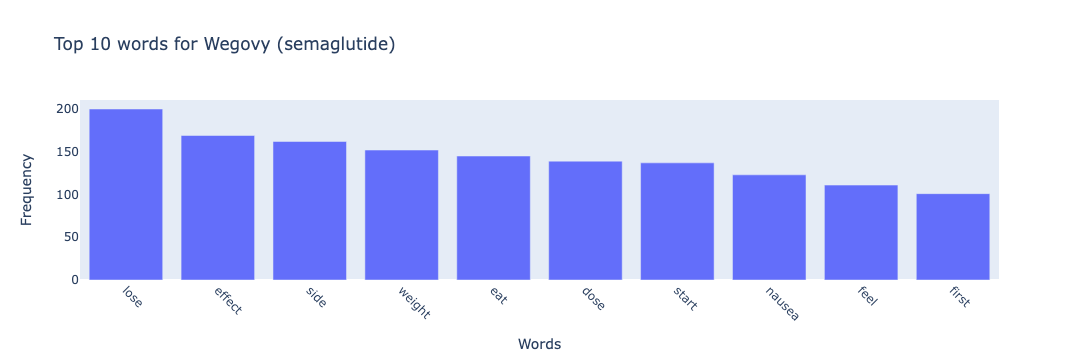

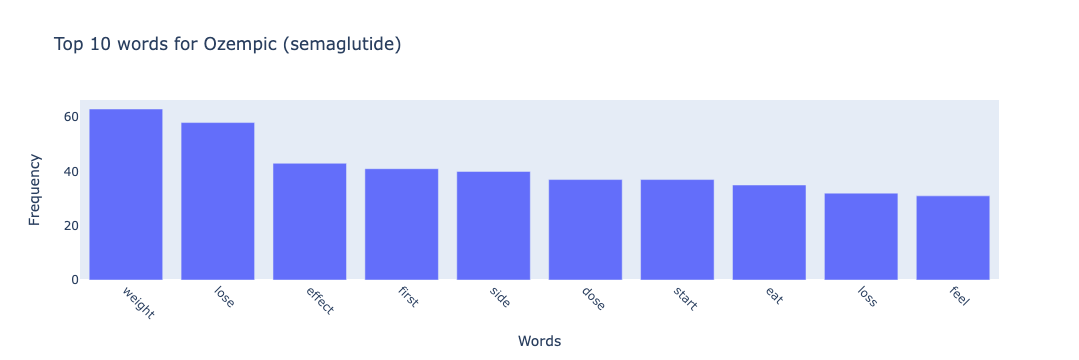

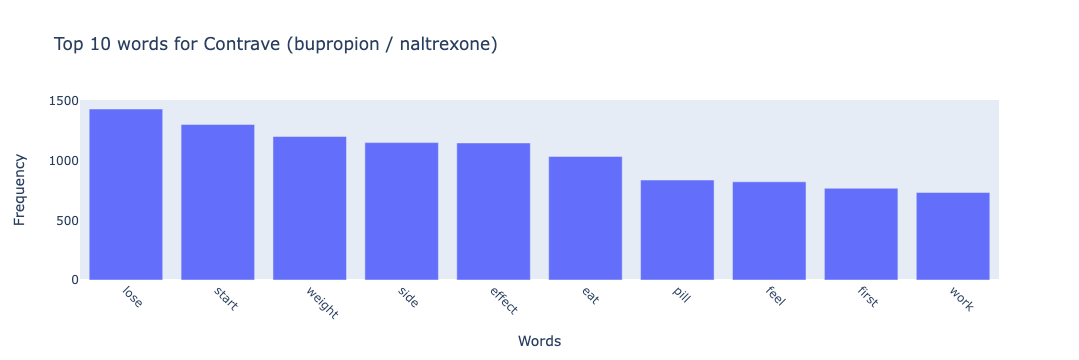

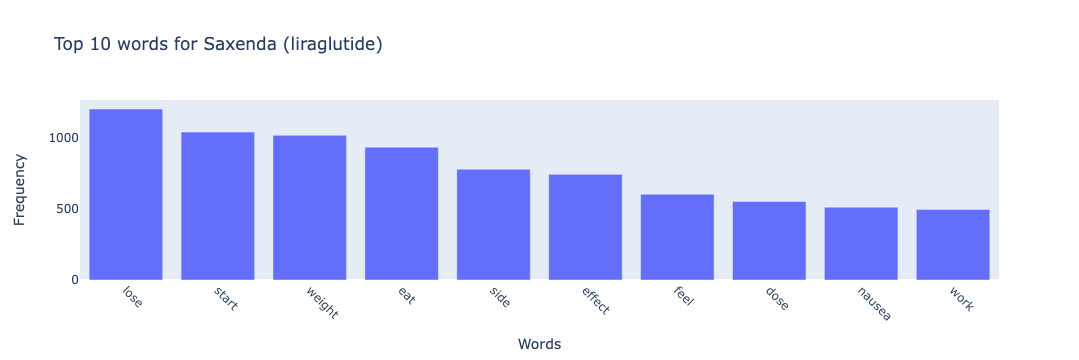

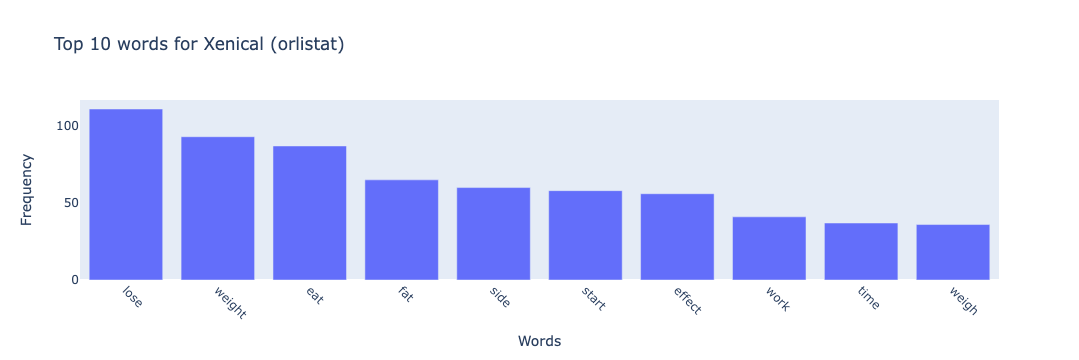

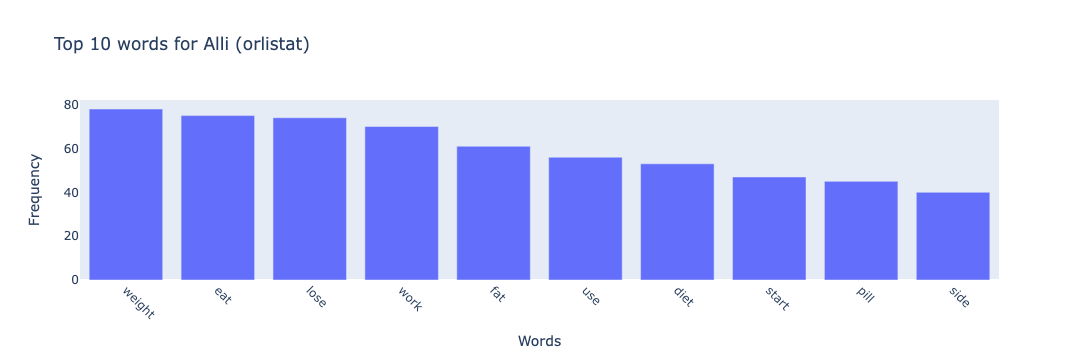

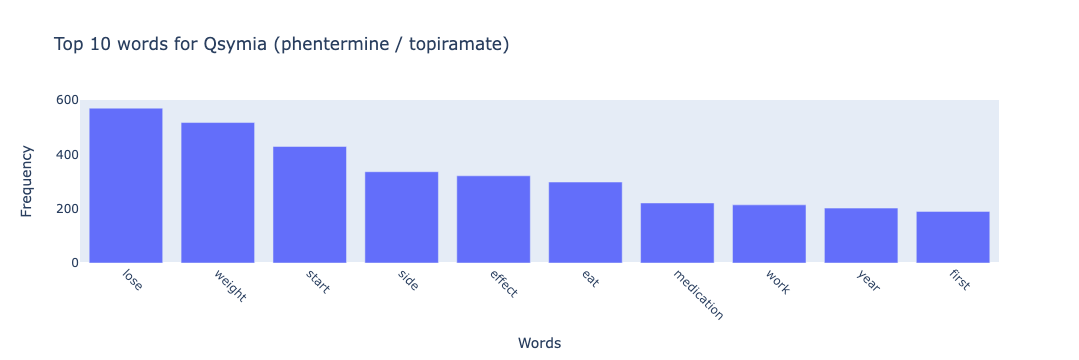

In [9]:
brand_drugs = ['Wegovy (semaglutide)', 'Ozempic (semaglutide)',\
               'Contrave (bupropion / naltrexone)', 'Saxenda (liraglutide)',\
               'Xenical (orlistat)', 'Alli (orlistat)', 'Qsymia (phentermine / topiramate)']
clean_drug_reviews2 = {drug: [] for drug in brand_drugs}
word_counts_by_drug2 = {drug: Counter() for drug in brand_drugs}

# Cleans and splits text
# And counts the words
for drug_name in brand_drugs:
    for review in drug_df.loc[drug_df['drugName'] == drug_name, 'review']:
        # Join the preprocessed words from a review into a single string with words separated by a space
        clean2 = " ".join(my_preprocessor2(review))  
        # Add the preprocessed review to the list of clean reviews for a specific drug
        clean_drug_reviews2[drug_name].append(clean2) 
        # Split the preprocessed review into individual words
        words2 = clean2.split()
        # Adds the individuals words to the list of words for a specific drug
        word_counts_by_drug2[drug_name].update(words2)

# Get the 10 most common words for each drug
top_words_by_drug2 = {drug: word_counts.most_common(10) for drug, word_counts in word_counts_by_drug2.items()}

# Create separate plots and tables for each drug
for drug_name, top_words in top_words_by_drug2.items():
    words, frequencies = zip(*top_words)
    df = pd.DataFrame({'Words': words, 'Frequency': frequencies})
    
    # Create a plot
    fig = px.bar(df, x='Words', y='Frequency',
                 title=f'Top 10 words for {drug_name}', labels={'Frequency': 'Frequency'})
    # Update figure properties
    fig.update_layout(xaxis=dict(tickangle=45, showgrid=False),
                      yaxis=dict(showgrid=False),
                     )
    # Show plot
    fig.show()

We can also combine all the separate plots into one plot with stacked bars for easier viewing.

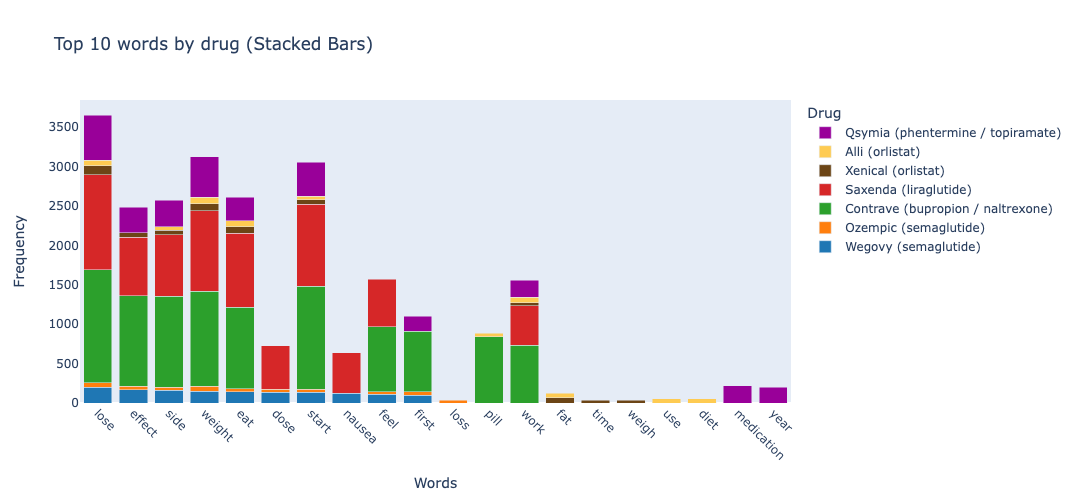

In [21]:
# Create an empty figure
fig = go.Figure()

# Define the custom color sequence
color_seq = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#6c4516", "#fecb52", "#990099"]

# Iterate over each drug and its top words
for i, (drug_name, top_words) in enumerate(top_words_by_drug2.items()):
    words, frequencies = zip(*top_words)
    df = pd.DataFrame({'Words': words, 'Frequency': frequencies})
    
    # Add stacked bar trace for each drug with custom color
    fig.add_trace(go.Bar(name=drug_name, x=df['Words'], y=df['Frequency'], marker_color=color_seq[i]))
    
# Update figure properties
fig.update_layout(
    title='Top 10 words by drug (Stacked Bars)',
    xaxis=dict(title='Words', tickangle=45, showgrid=False),
    yaxis=dict(title='Frequency', showgrid=False),
    barmode='stack',  # Stacked bars
    legend=dict(title='Drug'),  # Add legend
    width=800,  # Set the width to 800 pixels
    height=500,  # Set the height to 500 pixels
)

# Show the plot
fig.show()


We see that the first few words appear in the reviews for almost all of the drugs.

We can move on to looking at the frequency of some side effects in the reviews. Some common side effects of these drugs are nausea, vomiting, diarrhea, constipation, headache, dizziness, tired, fatigue. We can see if those words appear in the vocabulary of the individual drugs and at what frequency. When calculating frequency, we want to normalize the word frequencies for all drugs, which will allow for a better comparison of the relative importance of the selected words across different drugs.

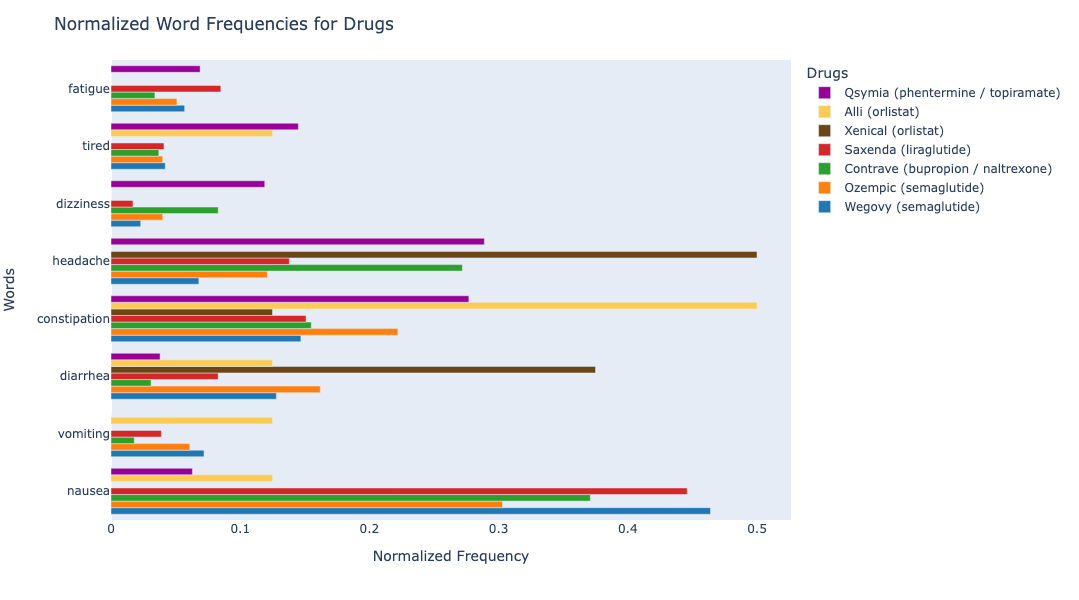

                               index  nausea  vomiting  diarrhea  \
0               Wegovy (semaglutide)   0.464     0.072     0.128   
1              Ozempic (semaglutide)   0.303     0.061     0.162   
2  Contrave (bupropion / naltrexone)   0.371     0.018     0.031   
3              Saxenda (liraglutide)   0.446     0.039     0.083   
4                 Xenical (orlistat)   0.000     0.000     0.375   
5                    Alli (orlistat)   0.125     0.125     0.125   
6  Qsymia (phentermine / topiramate)   0.063     0.000     0.038   

   constipation  headache  dizziness  tired  fatigue  
0         0.147     0.068      0.023  0.042    0.057  
1         0.222     0.121      0.040  0.040    0.051  
2         0.155     0.272      0.083  0.037    0.034  
3         0.151     0.138      0.017  0.041    0.085  
4         0.125     0.500      0.000  0.000    0.000  
5         0.500     0.000      0.000  0.125    0.000  
6         0.277     0.289      0.119  0.145    0.069  


In [22]:
selected_words = ['nausea', 'vomiting', 'diarrhea', 'constipation', 'headache', 'dizziness', 'tired', 'fatigue']

word_counts = {}

# Iterate over each drug and its word counts
for drug, counts in word_counts_by_drug2.items():
    # Initialize counts for selected words
    word_counts[drug] = {}

    # Check if selected words exist in the counts
    for word in selected_words:
        if word in counts:
            word_counts[drug][word] = counts[word]
        else:
            word_counts[drug][word] = 0

# Prepare data for plotting
drugs = list(word_counts.keys())
word_frequencies = np.array([[word_counts[drug][word] for word in selected_words] for drug in drugs])

# Normalize the word frequencies
total_counts = word_frequencies.sum(axis=1, keepdims=True)
word_frequencies_normalized = word_frequencies / total_counts

# Create dataframe from normalized word frequencies
df = pd.DataFrame(word_frequencies_normalized.round(3), columns=selected_words, index=drugs)

# Reset the index
df = df.reset_index()

# Melt the dataframe to convert columns to 'Words' and 'Normalized Frequency'
df_melted = pd.melt(df, id_vars='index', value_vars=selected_words, var_name='Words', value_name='Normalized Frequency')

# Plot the normalized word frequencies
fig = px.bar(df_melted, x='Normalized Frequency', y='Words', color='index', barmode='group', color_discrete_sequence=color_seq)
# Update figure properties
fig.update_layout(
    title='Normalized Word Frequencies for Drugs',
    xaxis_title='Normalized Frequency',
    yaxis_title='Words',
    legend_title='Drugs',
    height=600,
    width=700,
    yaxis=dict(showgrid=False),  # Remove the gridlines on the y-axis
    xaxis=dict(showgrid=False),  # Remove the gridlines on the x-axis
    legend=dict(
        traceorder='reversed'  # Reverse the order of the legend
    )
)
# Show figure
fig.show()

# Show the dataframe
print(df)

In the graph above, we see that all the side effects appear in the drugs, Wegovy, Ozempic, Contrave, and Saxenda. This may show the similarities in how the drug affects consumers.

### Topic Modeling with LDA <a class="anchor" id="lda"></a>

Next, we can move onto topic modeling. The first model we will use is Latent Dirichlet Allocation (LDA). It works by assigning probabilistic topic distributions to words in the documents.

We will employ the model with the `review` column.

In [12]:
# Baseline LDA Model
# Preprocess the reviews
preprocessed_reviews = [my_preprocessor2(review) for review in drug_df['review']]

# Create a Dictionary object from the preprocessed reviews
dictionary = Dictionary(preprocessed_reviews)

# Convert preprocessed documents to bag-of-words representation
bow_corpus = [dictionary.doc2bow(tokens) for tokens in preprocessed_reviews]

# Number of topics
num_topics = 10

# Build the LDA model
lda_model = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state = 42)

# Get the coherence score
coherence_model = CoherenceModel(model=lda_model, texts=preprocessed_reviews, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

# Print the coherence score
print(f"Coherence Score: {coherence_score.round(3)}")

# Print the top words for each topic
for topic in range(num_topics):
    top_words = lda_model.show_topic(topic, topn=10)
    print(f"Top words for Topic {topic+1}:")
    for word, prob in top_words:
        print(f"- {word}")
    print()

Coherence Score: 0.48
Top words for Topic 1:
- lose
- weight
- medication
- side
- effect
- phentermine
- could
- two
- experience
- med

Top words for Topic 2:
- start
- year
- old
- weight
- weigh
- lose
- female
- today
- back
- work

Top words for Topic 3:
- side
- effect
- lose
- start
- weight
- work
- good
- dose
- far
- medication

Top words for Topic 4:
- insurance
- cover
- pay
- weight
- cost
- doctor
- lose
- start
- medication
- work

Top words for Topic 5:
- nausea
- dose
- first
- appetite
- start
- lose
- side
- injection
- dosage
- increase

Top words for Topic 6:
- weight
- lose
- eat
- exercise
- help
- diet
- change
- loss
- year
- medication

Top words for Topic 7:
- eat
- start
- feel
- lose
- food
- time
- side
- first
- drink
- effect

Top words for Topic 8:
- bad
- felt
- effect
- like
- would
- stop
- pill
- could
- side
- feel

Top words for Topic 9:
- memory
- app
- free
- ideal
- difficulty
- awesome
- short
- care
- gluten
- pang

Top words for Topic 10:
-

We see the topics and the words associated for each topic. The words do not really explain the topics. We see that there is a coherence score of 48%. Coherence score is a measure that quantifies the interpretability and coherence of the topics generated by the model. 48% is pretty low so let's see if we can tune the hyperparameters to get a higher coherence score.

In [13]:
# Hyperparameter tuning
# Set up the parameter grid
param_grid = {
    'num_topics': range(6, 16, 2),
    'passes': range(6, 16, 2) 
}

best_coherence_score = -1
best_lda_model = None
results = []  # Store results

# Perform grid search
for num_topics in tqdm(param_grid['num_topics']):
    for passes in param_grid['passes']:
        # Build the LDA model
        lda_model = LdaModel(bow_corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state = 42)

        # Get the coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=preprocessed_reviews, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        # Check if this model has a better coherence score
        if coherence_score > best_coherence_score:
            best_coherence_score = coherence_score
            best_lda_model = lda_model

        # Store the results in a dictionary
        result = {
            'num_topics': num_topics,
            'passes': passes,
            'coherence_score': coherence_score
        }
        results.append(result)

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Print the best parameters and coherence score
best_num_topics = best_lda_model.num_topics
best_passes = best_lda_model.passes
print(f"Best Parameters: num_topics={best_num_topics}, passes={best_passes}")
print(f"Coherence Score: {best_coherence_score.round(3)}")

# Print the top words for each topic
for topic in range(best_num_topics):
    top_words = best_lda_model.show_topic(topic, topn=10)
    print(f"Top words for Topic {topic+1}:")
    for word, prob in top_words:
        print(f"- {word}")
    print()


100%|██████████| 5/5 [07:19<00:00, 87.97s/it]

Best Parameters: num_topics=6, passes=14
Coherence Score: 0.492
Top words for Topic 1:
- feel
- bad
- side
- effect
- could
- medication
- pill
- like
- sleep
- lose

Top words for Topic 2:
- start
- year
- lose
- mouth
- side
- effect
- weight
- old
- dry
- weigh

Top words for Topic 3:
- lose
- side
- effect
- weight
- start
- work
- first
- dose
- medication
- appetite

Top words for Topic 4:
- weight
- lose
- start
- doctor
- loss
- insurance
- year
- medication
- work
- cover

Top words for Topic 5:
- nausea
- dose
- first
- injection
- stomach
- diarrhea
- feel
- experience
- hour
- felt

Top words for Topic 6:
- eat
- lose
- food
- weight
- feel
- start
- make
- time
- work
- help



### Topic Modelling in NMF <a class="anchor" id="nmf"></a>

We can move on to another topic modeling model. We will now use Non-negative matrix factorization (NMF). NMF captures patterns of co-occurring words to identify meaningful topics. The basis vectors represent topics, and the coefficients indicate their presence in documents. NMF is effective in extracting latent topics from text data by factorizing the matrix into interpretable components.

For the NMF model, we will use a Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer. This vectorizer is defined as the calculation of how relevant a word in a corpus is to a text. The meaning increases proportionally to the number of times in the text a word appears but is compensated by the word frequency in the corpus (dataset). In the TF-IDF model, we can adjust the number of words we are looking for (ngram_range) and run our models through each vectorizer.

In [14]:
# Unigrams
# Instantiate the vectorizer
vectorized1 = TfidfVectorizer(preprocessor = my_preprocessor2, # use our custom preprocessor
                             tokenizer = lambda l:l,           # skip tokenization, our preprocessor returns words
                             min_df = 20,                      # require words be in at least 20 documents
                             max_features = 500)               # limiting the maximum number of features to 500        

# Fit and transform the vectorizer
vectorized1.fit(drug_df.review)
drug_reviews_vec1 = vectorized1.transform(drug_df.review)


# Bigrams
# Instantiate the vectorizer
vectorized2 = TfidfVectorizer(preprocessor = my_preprocessor2, # use our custom preprocessor
                             tokenizer = lambda l:l,           # skip tokenization, our preprocessor returns words
                             min_df = 20,                      # require words be in at least 20 documents
                             max_features = 500,               # limiting the maximum number of features to 500        
                             ngram_range = (2,2))              # want bigrams

# Fit and transform the vectorizer
vectorized2.fit(drug_df.review)
drug_reviews_vec2 = vectorized2.transform(drug_df.review)


# Trigrams
# Instantiate the vectorizer
vectorized3 = TfidfVectorizer(preprocessor = my_preprocessor2, # use our custom preprocessor
                             tokenizer = lambda l:l,           # skip tokenization, our preprocessor returns words
                             min_df = 20,                      # require words be in at least 20 documents
                             max_features = 500,               # limiting the maximum number of features to 500        
                             ngram_range = (3,3))              # want trigrams

# Fit and transform the vectorizer
vectorized3.fit(drug_df.review)
drug_reviews_vec3 = vectorized3.transform(drug_df.review)

/Users/justinanguyen/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Now that we have instantiated all the vectors, we can put it through the NMF model to find the topics and the words associated with them. We can use 6 topics to compare this model to the LDA model.

In [15]:
# Number of topics we want
n_topics = 6 

# Instantiate the NMF model
model = NMF(n_components = n_topics, max_iter = 100, random_state = 42)

# Fit and transform the model
model.fit(drug_reviews_vec1) 
nmf_features = model.transform(drug_reviews_vec1)

# Let's look at our result as a dataframe with topics as rows and vocabulary as columns
components_df = pd.DataFrame(model.components_, columns=vectorized1.get_feature_names_out())

# A quick loop to get the top 10 words for each topic
for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
pill      1.196288
feel      1.017754
nausea    1.008802
first     0.842756
felt      0.830441
like      0.773743
one       0.751118
bad       0.722901
stop      0.621692
work      0.610911
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
weight      2.255323
lose        1.407425
loss        1.201546
gain        0.636963
work        0.629538
back        0.588344
diet        0.507715
exercise    0.472206
help        0.432433
drug        0.420636
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
effect        1.736960
side          1.715272
lose          0.493910
far           0.472704
experience    0.361571
mouth         0.338812
appetite      0.314619
dry           0.294494
dose          0.289092
medication    0.251169
Name: 2, dtype: float64


For topic 4 the words with the highest value are:
start     2.754134
today     0.961670
weigh     0.805113
since     0.348006
dose      0.3409

In [16]:
# Number of topics we want
n_topics = 6 

# Instantiate the NMF model
model2 = NMF(n_components = n_topics, max_iter = 100, random_state = 42)

# Fit and transform the model
model2.fit(drug_reviews_vec2) 
nmf_features2 = model2.transform(drug_reviews_vec2)

# Let's look at our result as a dataframe with topics as rows and vocabulary as columns
components_df2 = pd.DataFrame(model2.components_, columns=vectorized2.get_feature_names_out())

# A quick loop to get the top 10 words for each topic
for topic in range(components_df2.shape[0]):
    tmp = components_df2.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
side effect            3.922233
experience side        0.239405
lose side              0.200958
bad side               0.184278
effect first           0.139244
far side               0.131240
effect far             0.119445
effect constipation    0.115451
effect lose            0.101789
effect experience      0.101507
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
weight loss        2.928220
start weight       0.160927
help weight        0.144438
loss journey       0.116258
see weight         0.112018
loss medication    0.107991
diet exercise      0.092318
loss slow          0.083486
waste money        0.079621
curb appetite      0.078353
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
lose weight        2.736227
help lose          0.281756
diet exercise      0.226342
want lose          0.210325
start lose         0.175791
try lose           0.139425
would recommend    0.138771
st

In [17]:
# Number of topics we want
n_topics = 6 

# Instantiate the NMF model
model3 = NMF(n_components = n_topics, max_iter = 100, random_state = 42)

# Fit and transform the model
model3.fit(drug_reviews_vec3) 
nmf_features3 = model3.transform(drug_reviews_vec3)

# Let's look at our result as a dataframe with topics as rows and vocabulary as columns
components_df3 = pd.DataFrame(model3.components_, columns=vectorized3.get_feature_names_out())

# A quick loop to get the top 10 words for each topic
for topic in range(components_df3.shape[0]):
    tmp = components_df3.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 1 the words with the highest value are:
experience side effect      2.976145
side effect nausea          0.212938
side effect experience      0.130472
side effect start           0.129240
high blood pressure         0.129020
side effect constipation    0.124366
side effect except          0.108851
weight loss journey         0.078080
side effect like            0.076168
negative side effect        0.072312
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
lose side effect            3.240673
side effect constipation    0.477842
side effect experience      0.427575
side effect feel            0.204042
side effect except          0.176657
side effect far             0.161105
side effect little          0.135829
side effect minimal         0.130589
side effect worth           0.122660
good luck everyone          0.117299
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
drink lot water           2.648785
side effect experience 

Looking at the topics for each model, we don't see clusters that properly explain the reviews. There are no insights that we can make with these models.

## Conclusion <a class="anchor" id="conclusion"></a>

Using NLP, we extracted the 10 most common words from the reviews and 4 of the 10 words consistently appeared in all drug reviews. We also looked at a few side effects and how frequent they appear in the reviews. We see that all the side effects appear in the drugs, Wegovy, Ozempic, Contrave, and Saxenda. We then moved on to topic modeling with LDA and NMF models. Although some topics appeared promising, further fine-tuning is required to improve the model's performance and accuracy.